# Lab2 - TSP EA solution

In [57]:
from itertools import combinations
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass
from tqdm.auto import tqdm

In [58]:
CITIES = pd.read_csv('cities/italy.csv', header=None, names=['name', 'lat', 'lon'])

POPULATION_SIZE = len(CITIES)*5
OFFSPRING_SIZE = int(POPULATION_SIZE*0.5)
MAX_GENERATIONS = 200

# Reproducible random
rng = np.random.Generator(np.random.PCG64([POPULATION_SIZE, OFFSPRING_SIZE, MAX_GENERATIONS]))

In [59]:
# Save for each couple save -> ( distance, index of compared city )
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)), dtype=tuple)
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = (geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km, c2.Index)
    DIST_MATRIX[c2.Index, c1.Index] = (geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km, c1.Index)

## Helper Functions

In [60]:
def cost(path):
    circular_path = path + [path[0]]
    tot_dist = 0
    for i in range(len(circular_path)-1):
        tot_dist += DIST_MATRIX[circular_path[i],circular_path[i+1]][0]
    return tot_dist


In [61]:
def print_path(path):
    circular_path = path + [path[0]]
    print("Path:")
    for i in range(len(circular_path)-1):
        print(f"{CITIES.at[circular_path[i],'name']} -> {CITIES.at[circular_path[i+1],'name']} ({DIST_MATRIX[circular_path[i],circular_path[i+1]][0]:.2f}km)")

    print(f"\nNumber of steps: {len(circular_path)-1} , Total lenght: {cost(path):.2f} km")


In [62]:
def visualize_path(path):
    circular_path = path + [path[0]]
    x_coordinates = [CITIES.at[i,'lon'] for i in circular_path]
    y_coordinates = [CITIES.at[i,'lat'] for i in circular_path]

    plt.figure()
    plt.title("Path EA Resolution")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.axis('equal')
    plt.plot(x_coordinates,y_coordinates,marker='o', linestyle='-', color='b')
    plt.show()

In [63]:
@dataclass
class Individual:
    genome: list
    fitness: float = None

In [64]:
def parent_selection(population):
    candidates = sorted(rng.choice(population,4), key=lambda e: e.fitness)
    
    return candidates[0], candidates[3]

In [65]:
def max_distance(path):
    circular_path = path + [path[0]]
    distances = np.zeros(len(CITIES),dtype=tuple)
    for i in range(0,len(circular_path)-1):
        distances[i] = (DIST_MATRIX[circular_path[i],circular_path[i+1]][0],DIST_MATRIX[circular_path[i],circular_path[i+1]][1])

    sorted_dist = sorted(distances, key= lambda x: x[0])[:len(CITIES)//5]

    return sorted_dist[rng.integers(0,len(CITIES)//5)][1]


In [66]:
def inverover(p1: Individual, p2: Individual):
    x=0
    while x < 0.5:
        longest_dist_p2 = max_distance(p2.genome)

        index_p1 = p1.genome.index(p2.genome[longest_dist_p2])
        seq_len = rng.integers(0,len(CITIES)+index_p1)
        seq_len = seq_len % len(CITIES)

        child_genome = p1.genome.copy()
        child_genome[index_p1:index_p1+seq_len] = p1.genome[index_p1:index_p1+seq_len][::-1]
        
        if cost(child_genome)<cost(p1.genome):
            break
        x=rng.random()

    return Individual(child_genome)

    

In [67]:
def mutation(p:Individual):
    child_genome = p.genome.copy()
    x = 0
    while x < 0.6:
        if rng.random()<0.2:
            # Try changing the place of max distance
            longest_dist = max_distance(child_genome)
            
            exchange_i = rng.integers(0,len(CITIES))
        
            temp = child_genome[longest_dist]
            child_genome[longest_dist] = child_genome[exchange_i]
            child_genome[exchange_i] = temp
        else:
            # Try swapping random sequences
            seq_len = rng.integers(1,len(CITIES)//4) 
            start_i = rng.integers(0,len(CITIES)-seq_len)

            seq = child_genome[start_i:start_i+seq_len]
            genome_no_seq = child_genome[:start_i] + child_genome[start_i+seq_len:]

            new_i = rng.integers(0,len(genome_no_seq))
            new_genome = genome_no_seq[:new_i] + seq + genome_no_seq[new_i:]

            child_genome = new_genome

        # if the cost is less return the child 
        if cost(child_genome)<cost(p.genome):
                break

        x = rng.random()
    return Individual(child_genome)

    

In [68]:
def compute_fast_min(start):
    # Search min algorithm
    visited = np.full(len(CITIES), False)
    curr_city_i = start
    visited[curr_city_i] = True
    path = list()
    path.append(curr_city_i)

    while not np.all(visited):

        # Find the city with minimum distance and take the correspondig index to make it the next city
        next_city_tup= np.min(DIST_MATRIX[curr_city_i,np.logical_not(visited)])
        curr_city_i = next_city_tup[1]

        path.append(curr_city_i)
        visited[curr_city_i] = True
    
    return path


# EA Resolution

In [69]:
cities_idx = [i for i in range(len(CITIES))]

population = [Individual(compute_fast_min(i)) for i in range(len(CITIES))]

for i in population:
    i.fitness = cost(i.genome)

for _ in tqdm(range(MAX_GENERATIONS)):
    offspring = list()

    for _ in range(OFFSPRING_SIZE):
        
        p1,p2 = parent_selection(population)
        
        if rng.random() <0.6:
            o = inverover(p1,p2)
        else:
            o = mutation(p1)

        offspring.append(o)

    for i in offspring:
        i.fitness = cost(i.genome)

    population.extend(offspring)
    population.sort(key=lambda i: i.fitness)
    population = population[:POPULATION_SIZE]


100%|██████████| 200/200 [00:06<00:00, 29.92it/s]


Path:
Florence -> Prato (17.17km)
Prato -> Leghorn (74.02km)
Leghorn -> Sassari (344.66km)
Sassari -> Cagliari (173.89km)
Cagliari -> Palermo (390.28km)
Palermo -> Syracuse (206.47km)
Syracuse -> Catania (51.23km)
Catania -> Reggio di Calabria (84.28km)
Reggio di Calabria -> Messina (12.48km)
Messina -> Taranto (293.02km)
Taranto -> Bari (77.63km)
Bari -> Andria (50.18km)
Andria -> Foggia (67.42km)
Foggia -> Salerno (109.52km)
Salerno -> Naples (46.25km)
Naples -> Giugliano in Campania (11.15km)
Giugliano in Campania -> Latina (124.45km)
Latina -> Rome (56.84km)
Rome -> Terni (76.54km)
Terni -> Perugia (63.64km)
Perugia -> Pescara (165.50km)
Pescara -> Ancona (139.24km)
Ancona -> Rimini (90.60km)
Rimini -> Forlì (46.72km)
Forlì -> Ravenna (26.46km)
Ravenna -> Ferrara (66.67km)
Ferrara -> Padua (66.57km)
Padua -> Venice (36.07km)
Venice -> Trieste (115.09km)
Trieste -> Bolzano (209.68km)
Bolzano -> Trento (49.94km)
Trento -> Vicenza (67.35km)
Vicenza -> Verona (44.70km)
Verona -> Bresci

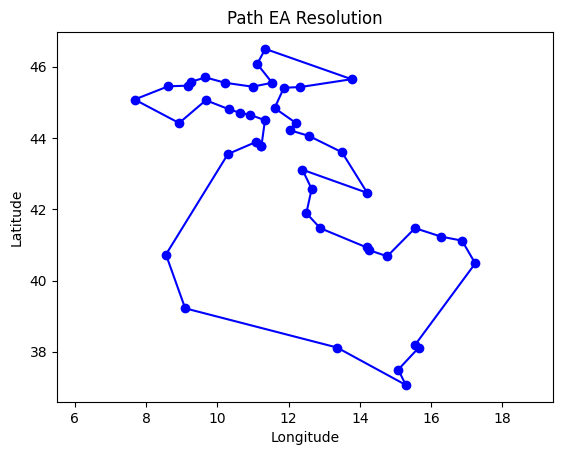

In [70]:
print_path(population[0].genome)
visualize_path(population[0].genome)